In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [2]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [3]:
data = np.load(open(input_fn, 'rb'))

In [4]:
X_train = data['X_train']

In [5]:
X_train.shape

(118024, 90, 18)

In [6]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [7]:
print(np.std(X_train.flatten()))

1.0000005


In [8]:
X_valid = data['X_valid']

In [9]:
X_test = data['X_test']

In [10]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [11]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [12]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [13]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [14]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [15]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [16]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [17]:
X.shape

(138745, 18, 90)

In [18]:
y.shape

(138745,)

In [19]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [20]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [21]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [22]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [23]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.1, 0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp])  # https://docs.fast.ai/optimizer
    # model parameters
}

In [24]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x15fe4fa8648>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x15fe4fa8c88>,
 'lr': <hyperopt.pyll.base.Apply at 0x15fe4fab408>,
 'epochs': <hyperopt.pyll.base.Apply at 0x15fe4faba08>,
 'patience': <hyperopt.pyll.base.Apply at 0x15fe4fabf88>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x15fe4fa45c8>}

In [25]:
X.shape

(138745, 18, 90)

In [26]:
time_steps = 30

In [27]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [28]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [29]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [30]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [31]:
import gc

In [32]:
# clear memory 
gc.collect()

192

In [33]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = ResCNN
        k = {}
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.001, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 90}
ResCNN                                                                                                                 
  0%|                                                                           | 0/30 [00:31<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,1.843887,1.837081,0.096472,00:07
1,1.795837,1.787052,0.123546,00:05
2,1.737641,1.724022,0.238261,00:05
3,1.664746,1.648597,0.491386,00:05
4,1.577068,1.559010,0.611650,00:05
5,1.481136,1.460210,0.642971,00:05
6,1.383748,1.360527,0.655084,00:05
7,1.292436,1.273665,0.660634,00:05
8,1.217903,1.205607,0.661551,00:05
9,1.161310,1.150555,0.661985,00:05


No improvement since epoch 52: early stopping                                                                          
  0%|                                                                           | 0/30 [06:15<?, ?trial/s, best loss=?]

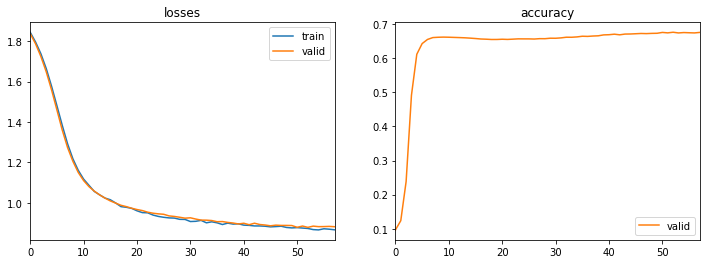

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'lr': 0.01, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 10, 'time_steps': 30}
ResCNN                                                                                                                 
  3%|█▌                                             | 1/30 [06:45<3:01:23, 375.29s/trial, best loss: 0.882474422454834]

epoch,train_loss,valid_loss,accuracy,time
0,1.574862,1.345010,0.636021,00:03
1,1.141879,1.041817,0.657208,00:02
2,1.019126,0.993390,0.654891,00:02
3,0.984287,0.976258,0.654746,00:02
4,0.964034,0.967400,0.655422,00:02
5,0.955965,0.960377,0.657449,00:02
6,0.950090,0.961600,0.657352,00:02
7,0.946391,0.959222,0.657739,00:02
8,0.946355,0.960444,0.657546,00:02
9,0.944869,0.959690,0.657642,00:02


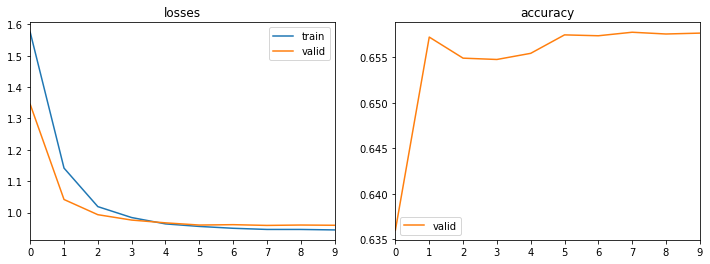

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.1, 'optimizer': <function RMSProp at 0x0000015FA4E5C318>, 'patience': 10, 'time_steps': 90}
ResCNN                                                                                                                 
  7%|███▏                                           | 2/30 [07:43<2:10:32, 279.75s/trial, best loss: 0.882474422454834]

epoch,train_loss,valid_loss,accuracy,time
0,0.923848,1.199921,0.668452,00:07
1,1.143681,0.923367,0.662323,00:06
2,0.955482,0.984173,0.640558,00:06
3,1.102909,1.038042,0.625356,00:06
4,0.746573,0.971087,0.625211,00:07
5,0.698470,1.010701,0.676270,00:06
6,0.653888,0.961199,0.684909,00:06
7,0.605352,1.110520,0.657449,00:06
8,0.566559,1.133047,0.667970,00:06
9,0.561178,1.194860,0.661648,00:06


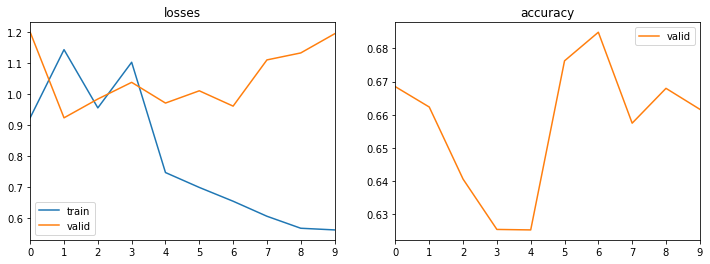

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.001, 'optimizer': <function RMSProp at 0x0000015FA4E5C318>, 'patience': 5, 'time_steps': 60}
ResCNN                                                                                                                 
 10%|████▋                                          | 3/30 [09:17<1:41:37, 225.83s/trial, best loss: 0.882474422454834]

epoch,train_loss,valid_loss,accuracy,time
0,1.012713,0.998045,0.654312,00:06
1,0.897672,0.917169,0.669562,00:05
2,0.856187,0.886100,0.676077,00:05
3,0.831405,0.915344,0.665412,00:05
4,0.807604,0.867794,0.684957,00:05
5,0.785152,0.923473,0.672024,00:05
6,0.765958,0.942178,0.677911,00:05
7,0.733891,1.041324,0.654553,00:05
8,0.692024,0.929452,0.677380,00:05
9,0.626808,1.145605,0.665315,00:05


No improvement since epoch 4: early stopping                                                                           
 10%|████▋                                          | 3/30 [10:14<1:41:37, 225.83s/trial, best loss: 0.882474422454834]

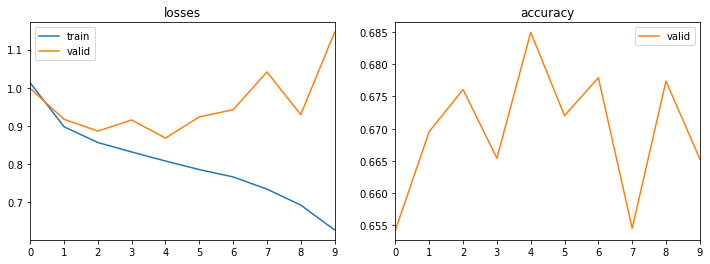

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.0001, 'optimizer': <function Adam at 0x0000015FA4E5C558>, 'patience': 10, 'time_steps': 30}
ResCNN                                                                                                                 
 13%|██████▎                                        | 4/30 [10:40<1:19:15, 182.90s/trial, best loss: 0.882474422454834]

epoch,train_loss,valid_loss,accuracy,time
0,1.239085,1.209368,0.620047,00:05
1,0.958323,0.940927,0.672072,00:05
2,0.897694,0.929966,0.674340,00:05
3,0.852224,0.938761,0.676319,00:05
4,0.841041,0.978084,0.663047,00:05
5,0.818670,0.948902,0.672458,00:05
6,0.792424,0.960986,0.671493,00:05
7,0.776800,0.981038,0.665315,00:05
8,0.766362,0.975727,0.666618,00:05
9,0.774188,0.978056,0.667198,00:05


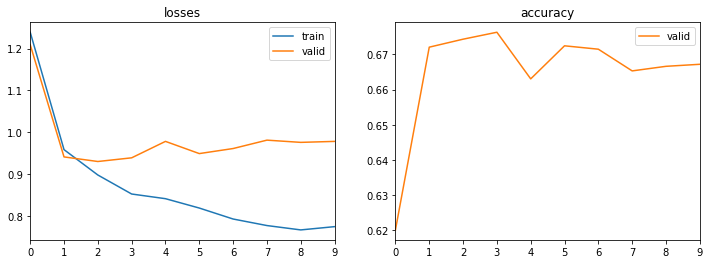

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.01, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 60}
ResCNN                                                                                                                 
 17%|███████▊                                       | 5/30 [12:02<1:03:38, 152.72s/trial, best loss: 0.882474422454834]

epoch,train_loss,valid_loss,accuracy,time
0,1.650555,1.576114,0.632498,00:04
1,1.501860,1.423332,0.651368,00:03
2,1.360759,1.289820,0.653106,00:03
3,1.240311,1.191696,0.654553,00:03
4,1.155533,1.126761,0.656001,00:03
5,1.099471,1.082268,0.656725,00:04
6,1.059376,1.049448,0.656773,00:04
7,1.031366,1.021482,0.656098,00:03
8,1.006727,0.998294,0.655615,00:04
9,0.987360,0.981600,0.655663,00:04


No improvement since epoch 41: early stopping                                                                          
 17%|███████▊                                       | 5/30 [15:18<1:03:38, 152.72s/trial, best loss: 0.882474422454834]

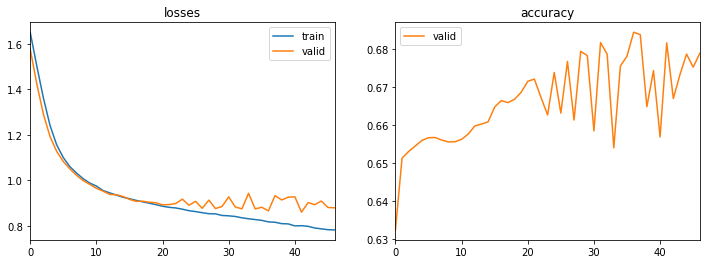

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.001, 'optimizer': <function Adam at 0x0000015FA4E5C558>, 'patience': 10, 'time_steps': 90}
ResCNN                                                                                                                 
 20%|█████████▏                                    | 6/30 [15:49<1:09:21, 173.41s/trial, best loss: 0.8785693049430847]

epoch,train_loss,valid_loss,accuracy,time
0,1.543030,1.527105,0.554799,00:06
1,1.308726,1.306962,0.608030,00:05
2,1.143861,1.123865,0.646204,00:05
3,1.013658,0.996408,0.659042,00:05
4,0.916055,0.942177,0.666618,00:05
5,0.856273,0.858900,0.680180,00:05
6,0.812489,0.862142,0.677863,00:05
7,0.771231,0.890449,0.674581,00:05
8,0.737980,0.959971,0.665412,00:05
9,0.707668,0.923668,0.681627,00:05


No improvement since epoch 5: early stopping                                                                           
 20%|█████████▏                                    | 6/30 [17:23<1:09:21, 173.41s/trial, best loss: 0.8785693049430847]

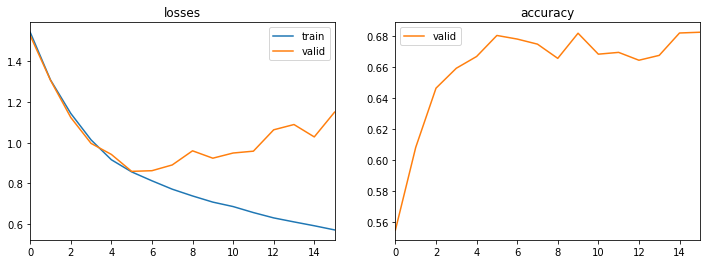

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'lr': 0.1, 'optimizer': <function Adam at 0x0000015FA4E5C558>, 'patience': 5, 'time_steps': 30}
ResCNN                                                                                                                 
 23%|██████████▋                                   | 7/30 [17:52<1:00:53, 158.86s/trial, best loss: 0.8785693049430847]

epoch,train_loss,valid_loss,accuracy,time
0,0.956924,0.922483,0.665315,00:02
1,0.911947,0.945934,0.674388,00:02
2,0.873875,1.031088,0.631244,00:02
3,0.839495,1.059417,0.655084,00:02
4,0.811017,1.069000,0.656484,00:02
5,0.781770,1.111861,0.645046,00:02


No improvement since epoch 0: early stopping                                                                           
 23%|██████████▋                                   | 7/30 [18:07<1:00:53, 158.86s/trial, best loss: 0.8785693049430847]

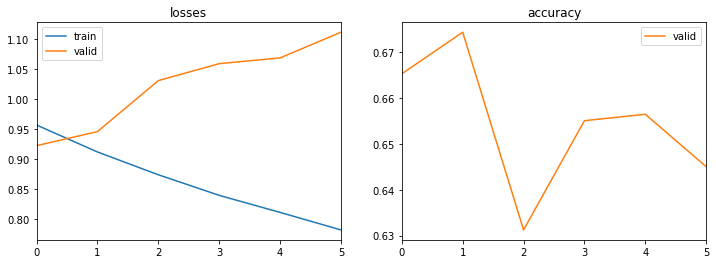

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'lr': 0.0001, 'optimizer': <function RMSProp at 0x0000015FA4E5C318>, 'patience': 5, 'time_steps': 60}
ResCNN                                                                                                                 
 27%|████████████▊                                   | 8/30 [18:36<45:38, 124.46s/trial, best loss: 0.8785693049430847]

epoch,train_loss,valid_loss,accuracy,time
0,1.546849,1.595267,0.534916,00:04
1,1.251406,1.198485,0.636214,00:04
2,1.068042,1.134610,0.612036,00:04
3,0.964148,0.947203,0.666618,00:04
4,0.908981,0.926852,0.670962,00:04
5,0.871779,0.913257,0.669659,00:04
6,0.853478,0.911663,0.668549,00:04
7,0.840800,0.900463,0.669948,00:04
8,0.834128,0.897145,0.671348,00:04
9,0.832322,0.898385,0.671444,00:04


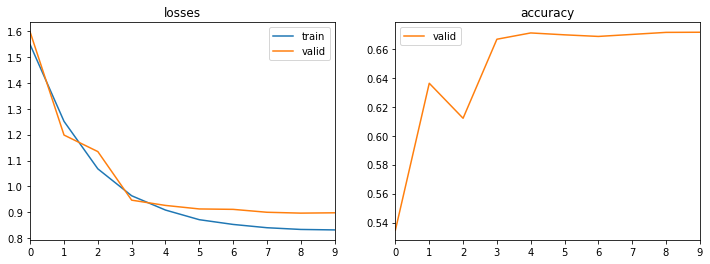

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.0001, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 10, 'time_steps': 60}
ResCNN                                                                                                                 
 30%|██████████████▍                                 | 9/30 [19:45<37:51, 108.16s/trial, best loss: 0.8785693049430847]

epoch,train_loss,valid_loss,accuracy,time
0,1.926238,1.894699,0.092177,00:03
1,1.923767,1.892842,0.092418,00:03
2,1.920423,1.888656,0.093384,00:03
3,1.915618,1.884484,0.093528,00:03
4,1.910033,1.877853,0.094107,00:03
5,1.901712,1.869822,0.095024,00:04
6,1.891876,1.858462,0.096762,00:03
7,1.879302,1.846244,0.099899,00:03
8,1.864381,1.831525,0.103422,00:04
9,1.845993,1.813266,0.112060,00:04


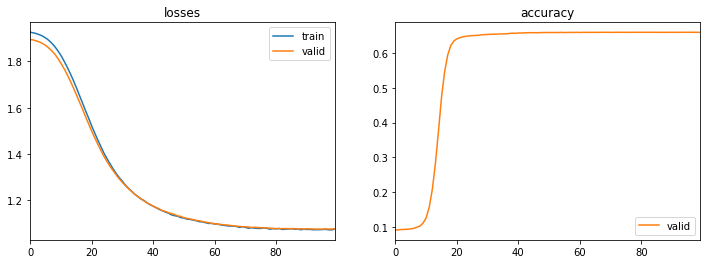

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'lr': 0.01, 'optimizer': <function Adam at 0x0000015FA4E5C558>, 'patience': 10, 'time_steps': 90}
ResCNN                                                                                                                 
 33%|███████████████                              | 10/30 [27:09<1:09:47, 209.39s/trial, best loss: 0.8785693049430847]

epoch,train_loss,valid_loss,accuracy,time
0,0.925587,0.945349,0.666136,00:05
1,0.805883,1.184266,0.629072,00:05
2,0.739554,0.872952,0.681483,00:05
3,0.659017,1.239678,0.529029,00:05
4,0.585871,1.040721,0.622171,00:05
5,0.523206,1.175249,0.658704,00:05
6,0.459854,1.237324,0.614304,00:05
7,0.396242,1.372339,0.652575,00:05
8,0.340608,1.621610,0.649631,00:06
9,0.306604,1.593420,0.640075,00:05


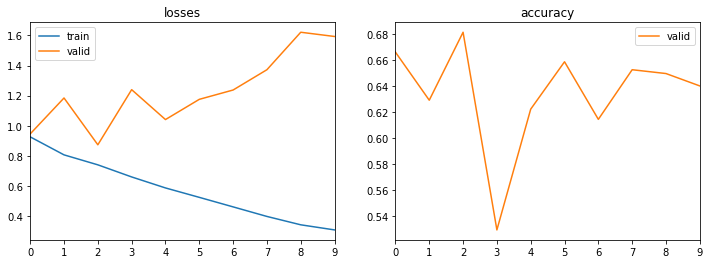

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.0001, 'optimizer': <function Adam at 0x0000015FA4E5C558>, 'patience': 10, 'time_steps': 60}
ResCNN                                                                                                                 
 37%|█████████████████▏                             | 11/30 [28:37<54:24, 171.82s/trial, best loss: 0.8785693049430847]

epoch,train_loss,valid_loss,accuracy,time
0,1.839135,1.869056,0.281695,00:04
1,1.748062,1.818519,0.443849,00:04
2,1.657163,1.762884,0.494860,00:04
3,1.566715,1.660860,0.530862,00:04
4,1.481703,1.558541,0.560301,00:04
5,1.397635,1.442258,0.588871,00:04
6,1.317787,1.356906,0.607886,00:04
7,1.237413,1.267504,0.618599,00:04
8,1.161891,1.192584,0.629989,00:04
9,1.094255,1.110263,0.638434,00:04


No improvement since epoch 16: early stopping                                                                          
 37%|█████████████████▏                             | 11/30 [30:30<54:24, 171.82s/trial, best loss: 0.8785693049430847]

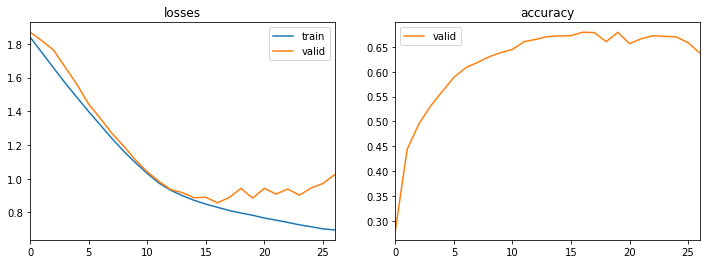

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'lr': 0.0001, 'optimizer': <function RMSProp at 0x0000015FA4E5C318>, 'patience': 10, 'time_steps': 90}
ResCNN                                                                                                                 
 40%|██████████████████▊                            | 12/30 [30:56<48:55, 163.06s/trial, best loss: 0.8785693049430847]

epoch,train_loss,valid_loss,accuracy,time
0,1.606863,1.604702,0.526953,00:05
1,1.290757,1.311597,0.612422,00:05
2,1.088692,1.068176,0.641041,00:05
3,0.972672,0.967710,0.664784,00:05
4,0.906761,0.906264,0.671831,00:05
5,0.868596,0.924127,0.668018,00:05
6,0.846498,0.906186,0.669707,00:05
7,0.830345,0.880052,0.679938,00:05
8,0.824841,0.886302,0.675643,00:05
9,0.819610,0.884096,0.676801,00:05


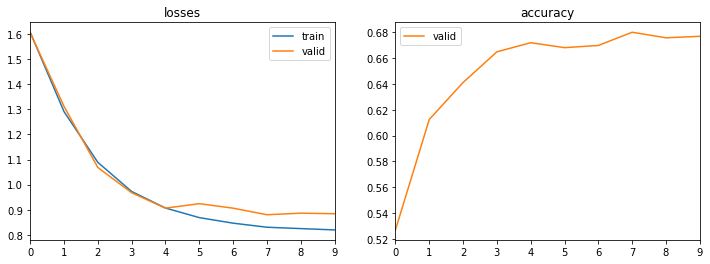

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.0001, 'optimizer': <function RMSProp at 0x0000015FA4E5C318>, 'patience': 5, 'time_steps': 30}
ResCNN                                                                                                                 
 43%|████████████████████▎                          | 13/30 [32:20<39:24, 139.11s/trial, best loss: 0.8785693049430847]

epoch,train_loss,valid_loss,accuracy,time
0,1.576591,1.639907,0.539694,00:03
1,1.440106,1.506062,0.581825,00:03
2,1.309898,1.332173,0.611264,00:03
3,1.189970,1.198824,0.625549,00:03
4,1.077356,1.066553,0.651706,00:03
5,0.990430,0.974076,0.666763,00:03
6,0.932267,0.948423,0.674051,00:03
7,0.899630,0.981538,0.661455,00:03
8,0.882881,0.948142,0.668983,00:03
9,0.868541,0.931769,0.674099,00:03


No improvement since epoch 11: early stopping                                                                          
 43%|████████████████████▎                          | 13/30 [33:14<39:24, 139.11s/trial, best loss: 0.8785693049430847]

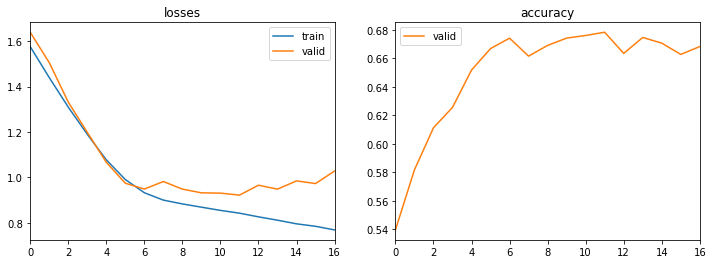

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.001, 'optimizer': <function Adam at 0x0000015FA4E5C558>, 'patience': 10, 'time_steps': 90}
ResCNN                                                                                                                 
 47%|█████████████████████▉                         | 14/30 [33:42<32:27, 121.70s/trial, best loss: 0.8785693049430847]

epoch,train_loss,valid_loss,accuracy,time
0,1.026311,0.994622,0.660103,00:07
1,0.882031,0.915655,0.658607,00:07
2,0.839368,0.858165,0.683703,00:07
3,0.806982,0.859382,0.684812,00:07
4,0.758452,0.856727,0.684040,00:07
5,0.736209,0.943198,0.673616,00:07
6,0.692286,0.953430,0.678780,00:07
7,0.668704,0.903223,0.687129,00:07
8,0.642636,0.938537,0.672892,00:07
9,0.581299,1.227688,0.654023,00:07


No improvement since epoch 4: early stopping                                                                           
 47%|█████████████████████▉                         | 14/30 [35:29<32:27, 121.70s/trial, best loss: 0.8785693049430847]

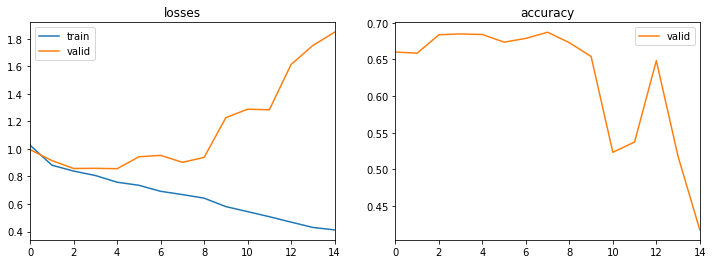

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.01, 'optimizer': <function RMSProp at 0x0000015FA4E5C318>, 'patience': 10, 'time_steps': 60}
ResCNN                                                                                                                 
 50%|███████████████████████▌                       | 15/30 [35:57<31:24, 125.62s/trial, best loss: 0.8785693049430847]

epoch,train_loss,valid_loss,accuracy,time
0,0.853870,0.834710,0.692293,00:05
1,0.775134,0.960291,0.686743,00:05
2,0.717885,1.075774,0.672699,00:05
3,0.660392,1.121390,0.655856,00:05
4,0.615179,1.040990,0.605811,00:05
5,0.571386,1.240184,0.611843,00:05
6,0.541975,1.086915,0.657256,00:05
7,0.533097,2.607908,0.276386,00:05
8,0.500305,1.419098,0.480624,00:05
9,0.495400,2.707112,0.250084,00:05


No improvement since epoch 0: early stopping                                                                           
 50%|███████████████████████▌                       | 15/30 [36:59<31:24, 125.62s/trial, best loss: 0.8785693049430847]

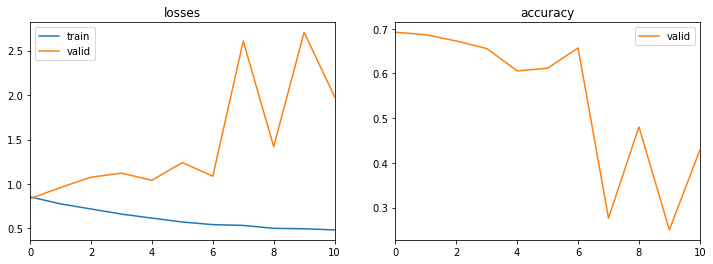

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.001, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 90}
ResCNN                                                                                                                 
 53%|█████████████████████████                      | 16/30 [37:27<26:50, 115.00s/trial, best loss: 0.8785693049430847]

epoch,train_loss,valid_loss,accuracy,time
0,1.703485,1.717833,0.412239,00:06
1,1.615051,1.625250,0.526712,00:06
2,1.516021,1.527139,0.614256,00:06
3,1.408952,1.417754,0.642344,00:06
4,1.305076,1.313239,0.657835,00:06
5,1.224422,1.226562,0.661937,00:06
6,1.149360,1.160435,0.661889,00:06
7,1.098572,1.112524,0.661165,00:06
8,1.058586,1.073803,0.660393,00:06
9,1.040295,1.040883,0.660152,00:06


No improvement since epoch 59: early stopping                                                                          
 53%|█████████████████████████                      | 16/30 [45:03<26:50, 115.00s/trial, best loss: 0.8785693049430847]

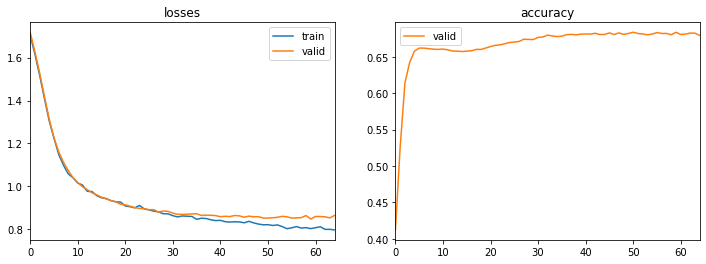

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 10, 'lr': 0.1, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 30}
ResCNN                                                                                                                 
 57%|██████████████████████████▋                    | 17/30 [45:31<48:54, 225.76s/trial, best loss: 0.8647282123565674]

epoch,train_loss,valid_loss,accuracy,time
0,1.098828,1.005438,0.653202,00:02
1,0.971165,0.972493,0.665605,00:02
2,0.936098,0.959923,0.663240,00:02
3,0.904104,0.945932,0.667777,00:02
4,0.887605,0.929247,0.669321,00:02
5,0.862069,0.955081,0.666329,00:02
6,0.839446,0.933560,0.669321,00:02
7,0.819845,0.951865,0.665460,00:02
8,0.810673,0.962074,0.666956,00:02
9,0.805821,0.955902,0.665991,00:02


No improvement since epoch 4: early stopping                                                                           
 57%|██████████████████████████▋                    | 17/30 [45:56<48:54, 225.76s/trial, best loss: 0.8647282123565674]

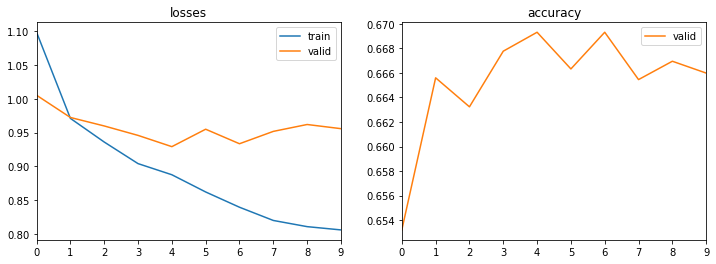

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.001, 'optimizer': <function RMSProp at 0x0000015FA4E5C318>, 'patience': 10, 'time_steps': 60}
ResCNN                                                                                                                 
 60%|████████████████████████████▏                  | 18/30 [46:29<34:44, 173.74s/trial, best loss: 0.8647282123565674]

epoch,train_loss,valid_loss,accuracy,time
0,1.140192,1.136015,0.636649,00:05
1,0.965774,0.921137,0.668549,00:04
2,0.888590,0.891622,0.672024,00:04
3,0.856756,0.878782,0.682158,00:04
4,0.829178,0.953608,0.665701,00:05
5,0.798126,1.029148,0.618551,00:04
6,0.764881,1.068120,0.641957,00:04
7,0.716322,0.980652,0.638531,00:04
8,0.665577,0.973214,0.643309,00:04
9,0.611184,1.059404,0.664254,00:04


No improvement since epoch 3: early stopping                                                                           
 60%|████████████████████████████▏                  | 18/30 [47:36<34:44, 173.74s/trial, best loss: 0.8647282123565674]

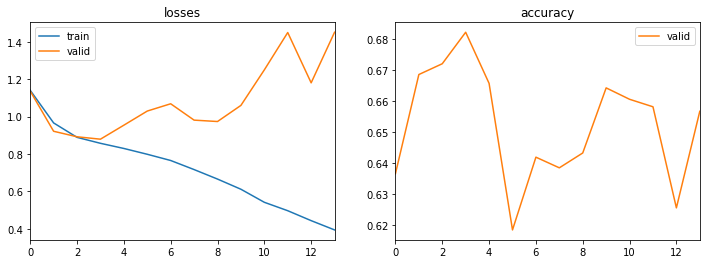

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.0001, 'optimizer': <function Adam at 0x0000015FA4E5C558>, 'patience': 5, 'time_steps': 90}
ResCNN                                                                                                                 
 63%|█████████████████████████████▊                 | 19/30 [48:08<27:49, 151.73s/trial, best loss: 0.8647282123565674]

epoch,train_loss,valid_loss,accuracy,time
0,1.810524,1.860303,0.289223,00:05
1,1.725855,1.813675,0.471985,00:05
2,1.631773,1.737319,0.520486,00:05
3,1.537796,1.624816,0.547705,00:05
4,1.451023,1.502765,0.583080,00:05
5,1.365338,1.421374,0.603446,00:05
6,1.287492,1.322929,0.623474,00:05
7,1.216408,1.240699,0.632402,00:05
8,1.148710,1.147987,0.643164,00:05
9,1.081570,1.062417,0.653926,00:05


No improvement since epoch 20: early stopping                                                                          
 63%|█████████████████████████████▊                 | 19/30 [50:44<27:49, 151.73s/trial, best loss: 0.8647282123565674]

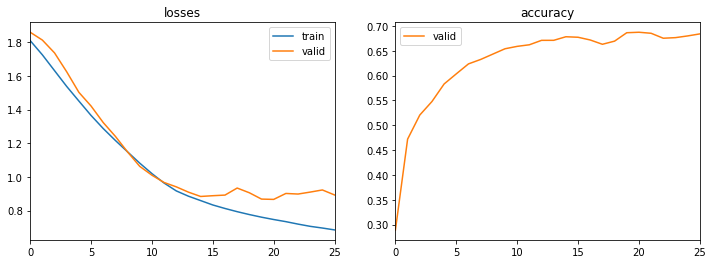

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.01, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 60}
ResCNN                                                                                                                 
 67%|███████████████████████████████▎               | 20/30 [51:11<27:07, 162.78s/trial, best loss: 0.8647282123565674]

epoch,train_loss,valid_loss,accuracy,time
0,1.298187,1.256802,0.651561,00:05
1,1.126709,1.117638,0.654071,00:05
2,1.047221,1.047008,0.655712,00:05
3,1.022585,1.000098,0.656146,00:05
4,0.977930,0.970525,0.656725,00:05
5,0.957107,0.947507,0.658559,00:05
6,0.941781,0.933613,0.660731,00:05
7,0.941504,0.927880,0.661599,00:05
8,0.918136,0.916296,0.664736,00:05
9,0.897226,0.905378,0.666763,00:05


No improvement since epoch 16: early stopping                                                                          
 67%|███████████████████████████████▎               | 20/30 [53:10<27:07, 162.78s/trial, best loss: 0.8647282123565674]

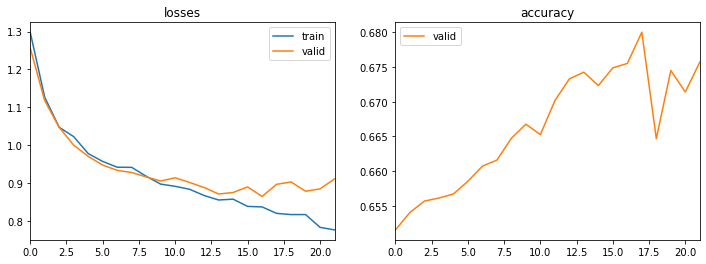

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.01, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 60}
ResCNN                                                                                                                 
 70%|████████████████████████████████▉              | 21/30 [53:37<23:39, 157.74s/trial, best loss: 0.8647282123565674]

epoch,train_loss,valid_loss,accuracy,time
0,1.359154,1.335048,0.638048,00:05
1,1.141447,1.141476,0.657256,00:05
2,1.065591,1.060149,0.661503,00:05
3,1.012578,1.011578,0.658607,00:05
4,0.984883,0.974519,0.658607,00:05
5,0.959798,0.951147,0.658462,00:05
6,0.945861,0.939715,0.659572,00:05
7,0.932830,0.930660,0.660634,00:05
8,0.920382,0.920832,0.665460,00:05
9,0.903456,0.904536,0.668983,00:05


No improvement since epoch 14: early stopping                                                                          
 70%|████████████████████████████████▉              | 21/30 [55:25<23:39, 157.74s/trial, best loss: 0.8647282123565674]

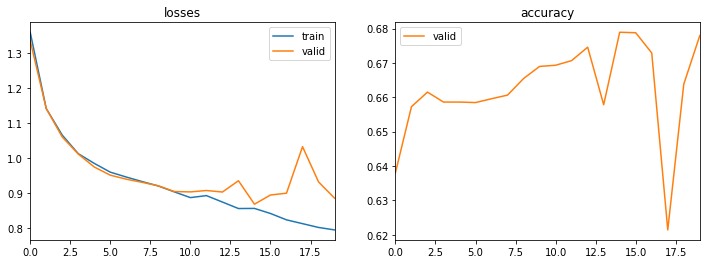

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.001, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 90}
ResCNN                                                                                                                 
 73%|██████████████████████████████████▍            | 22/30 [55:52<20:06, 150.86s/trial, best loss: 0.8647282123565674]

epoch,train_loss,valid_loss,accuracy,time
0,1.831565,1.839016,0.153612,00:05
1,1.781939,1.788973,0.217509,00:05
2,1.722218,1.723794,0.322716,00:05
3,1.648587,1.646725,0.494185,00:06
4,1.562755,1.555494,0.583128,00:06
5,1.471667,1.460508,0.616186,00:06
6,1.380536,1.369870,0.630423,00:06
7,1.298556,1.293481,0.638193,00:06
8,1.229854,1.232515,0.644467,00:06
9,1.176497,1.182268,0.652671,00:06


No improvement since epoch 78: early stopping                                                                          
 73%|█████████████████████████████████            | 22/30 [1:04:54<20:06, 150.86s/trial, best loss: 0.8647282123565674]

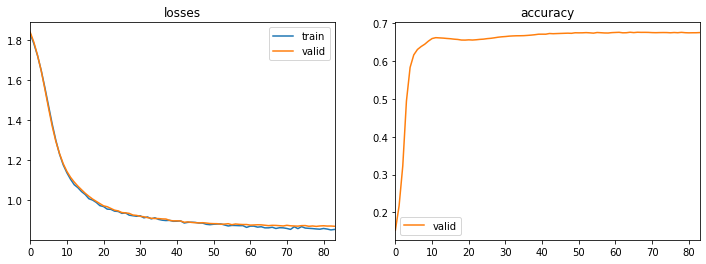

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.001, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 90}
ResCNN                                                                                                                 
 77%|██████████████████████████████████▌          | 23/30 [1:05:21<32:13, 276.27s/trial, best loss: 0.8647282123565674]

epoch,train_loss,valid_loss,accuracy,time
0,1.886676,1.884480,0.088268,00:05
1,1.816056,1.805575,0.158487,00:05
2,1.703616,1.682703,0.436852,00:06
3,1.549150,1.521942,0.609961,00:06
4,1.385055,1.360847,0.635153,00:06
5,1.253435,1.236576,0.647411,00:06
6,1.160410,1.157675,0.656049,00:06
7,1.114666,1.107826,0.658028,00:06
8,1.069458,1.075955,0.657159,00:06
9,1.049295,1.048062,0.656435,00:06


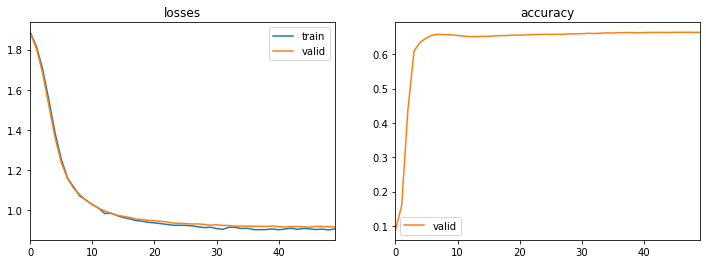

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.001, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 90}
ResCNN                                                                                                                 
 80%|████████████████████████████████████         | 24/30 [1:11:12<29:52, 298.80s/trial, best loss: 0.8647282123565674]

epoch,train_loss,valid_loss,accuracy,time
0,1.692615,1.673253,0.295159,00:05
1,1.651374,1.631282,0.450943,00:05
2,1.602393,1.578407,0.591284,00:06
3,1.540153,1.517571,0.636794,00:06
4,1.469266,1.444891,0.649196,00:06
5,1.393442,1.369831,0.653733,00:06
6,1.312329,1.297151,0.657159,00:06
7,1.244093,1.232360,0.659814,00:06
8,1.195751,1.179110,0.661841,00:06
9,1.146726,1.139948,0.662130,00:06


No improvement since epoch 71: early stopping                                                                          
 80%|████████████████████████████████████         | 24/30 [1:19:38<29:52, 298.80s/trial, best loss: 0.8647282123565674]

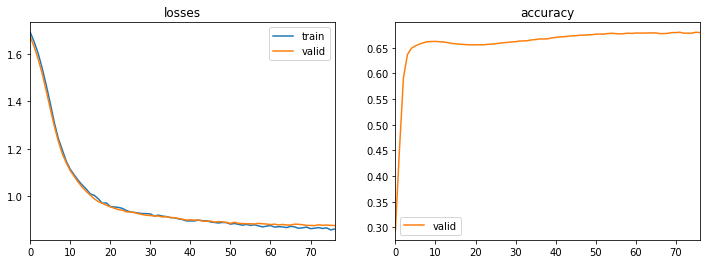

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.001, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 90}
ResCNN                                                                                                                 
 83%|█████████████████████████████████████▌       | 25/30 [1:20:04<30:43, 368.77s/trial, best loss: 0.8647282123565674]

epoch,train_loss,valid_loss,accuracy,time
0,1.858389,1.850768,0.068385,00:05
1,1.810794,1.799004,0.112157,00:05
2,1.748172,1.737723,0.269582,00:06
3,1.674002,1.656163,0.433956,00:06
4,1.584150,1.565377,0.563776,00:06
5,1.484190,1.465525,0.625597,00:06
6,1.385514,1.371954,0.633126,00:06
7,1.288908,1.284175,0.643019,00:06
8,1.216818,1.213158,0.651127,00:06
9,1.153822,1.160653,0.657642,00:06


No improvement since epoch 62: early stopping                                                                          
 83%|█████████████████████████████████████▌       | 25/30 [1:27:32<30:43, 368.77s/trial, best loss: 0.8647282123565674]

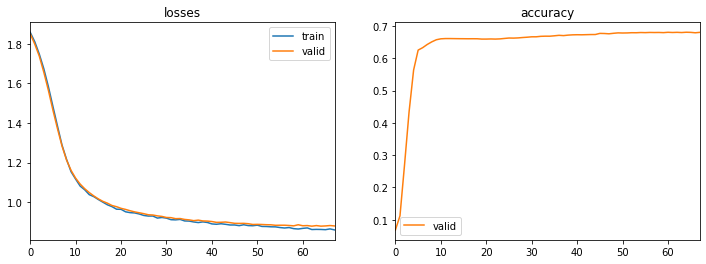

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.001, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 90}
ResCNN                                                                                                                 
 87%|███████████████████████████████████████      | 26/30 [1:27:58<26:41, 400.40s/trial, best loss: 0.8647282123565674]

epoch,train_loss,valid_loss,accuracy,time
0,1.849477,1.842003,0.052652,00:05
1,1.800719,1.795902,0.120988,00:05
2,1.740631,1.734447,0.375754,00:06
3,1.668318,1.661665,0.544134,00:06
4,1.581499,1.574393,0.586458,00:06
5,1.487066,1.479620,0.599585,00:06
6,1.391598,1.384298,0.612567,00:06
7,1.303890,1.299413,0.624342,00:06
8,1.223423,1.229553,0.636021,00:06
9,1.171569,1.172359,0.647459,00:06


No improvement since epoch 58: early stopping                                                                          
 87%|███████████████████████████████████████      | 26/30 [1:35:01<26:41, 400.40s/trial, best loss: 0.8647282123565674]

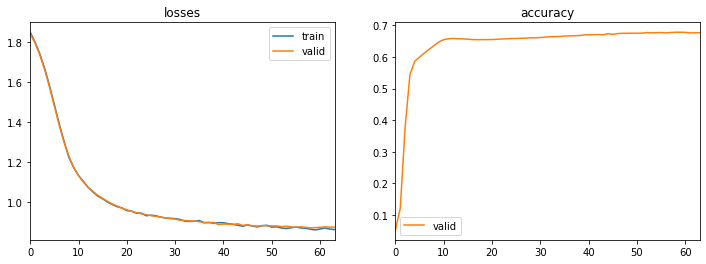

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'lr': 0.001, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 90}
ResCNN                                                                                                                 
 90%|████████████████████████████████████████▌    | 27/30 [1:35:27<20:45, 415.04s/trial, best loss: 0.8647282123565674]

epoch,train_loss,valid_loss,accuracy,time
0,1.715369,1.715096,0.177163,00:06
1,1.590849,1.586639,0.367357,00:06
2,1.422513,1.413165,0.607741,00:06
3,1.253900,1.247397,0.650693,00:06
4,1.145054,1.145738,0.655856,00:07
5,1.080613,1.091245,0.656484,00:07
6,1.041361,1.053360,0.655808,00:07
7,1.016085,1.022162,0.655036,00:07
8,0.997992,0.998264,0.653636,00:07
9,0.975972,0.980151,0.654312,00:07


No improvement since epoch 38: early stopping                                                                          
 90%|████████████████████████████████████████▌    | 27/30 [1:40:48<20:45, 415.04s/trial, best loss: 0.8647282123565674]

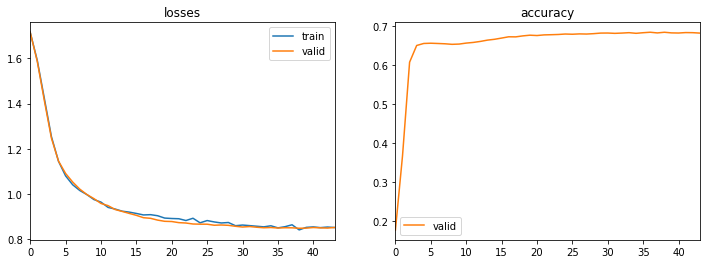

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'lr': 0.001, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 90}
ResCNN                                                                                                                 
 93%|██████████████████████████████████████████   | 28/30 [1:41:14<13:09, 394.53s/trial, best loss: 0.8525614738464355]

epoch,train_loss,valid_loss,accuracy,time
0,1.706749,1.725208,0.298924,00:06
1,1.591635,1.603375,0.572656,00:06
2,1.428231,1.435466,0.634043,00:06
3,1.272474,1.277720,0.649727,00:06
4,1.158493,1.172036,0.656387,00:07
5,1.090279,1.109300,0.660875,00:07
6,1.058524,1.067107,0.660055,00:07
7,1.015962,1.033604,0.658269,00:07
8,0.997764,1.007721,0.656387,00:07
9,0.966646,0.986206,0.654409,00:07


No improvement since epoch 39: early stopping                                                                          
 93%|██████████████████████████████████████████   | 28/30 [1:46:43<13:09, 394.53s/trial, best loss: 0.8525614738464355]

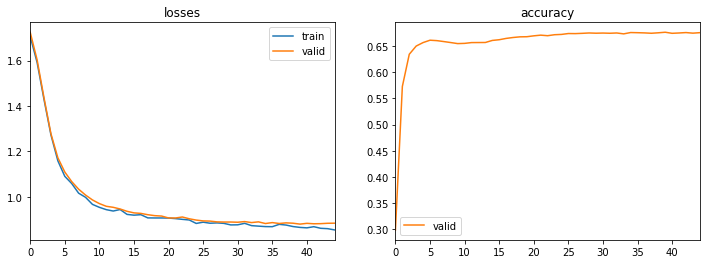

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'lr': 0.001, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 90}
ResCNN                                                                                                                 
 97%|███████████████████████████████████████████▌ | 29/30 [1:47:09<06:22, 382.69s/trial, best loss: 0.8525614738464355]

epoch,train_loss,valid_loss,accuracy,time
0,1.738028,1.735119,0.124560,00:06
1,1.612793,1.601381,0.521452,00:06
2,1.439344,1.423483,0.649003,00:06
3,1.271467,1.251106,0.661599,00:06
4,1.153593,1.145877,0.661744,00:07
5,1.090859,1.082355,0.659717,00:07
6,1.051055,1.040507,0.657594,00:07
7,1.005838,1.005365,0.655663,00:07
8,0.980001,0.978030,0.654602,00:07
9,0.959044,0.954763,0.656049,00:07


No improvement since epoch 35: early stopping                                                                          
 97%|███████████████████████████████████████████▌ | 29/30 [1:52:08<06:22, 382.69s/trial, best loss: 0.8525614738464355]

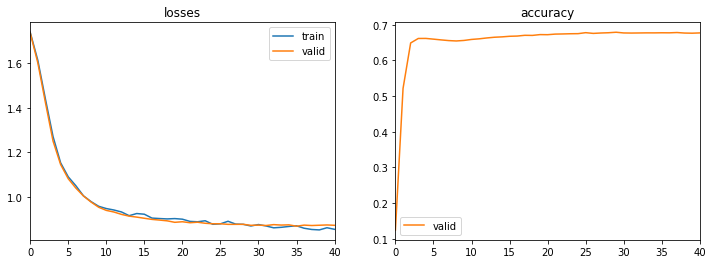

100%|█████████████████████████████████████████████| 30/30 [1:52:09<00:00, 224.30s/trial, best loss: 0.8525614738464355]


In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bs': 0, 'epochs': 1, 'lr': 2, 'optimizer': 1, 'patience': 0, 'ts': 2}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 256, 'epochs': 50, 'lr': 0.001, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 90}


In [38]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = ResCNN
    k = {}
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 256, 'epochs': 50, 'lr': 0.001, 'optimizer': <function SGD at 0x0000015FA4E5C1F8>, 'patience': 5, 'time_steps': 90}
ResCNN


epoch,train_loss,valid_loss,accuracy,time
0,1.736951,1.733124,0.225810,00:06
1,1.608128,1.600137,0.545437,00:06
2,1.436229,1.423237,0.639207,00:06
3,1.268120,1.267164,0.656194,00:06
4,1.154828,1.159478,0.659090,00:07
5,1.091973,1.097353,0.658173,00:07
6,1.050603,1.053442,0.655808,00:07
7,1.008402,1.018251,0.654167,00:07
8,0.994616,0.994742,0.654264,00:07
9,0.969072,0.975277,0.655181,00:07


No improvement since epoch 32: early stopping


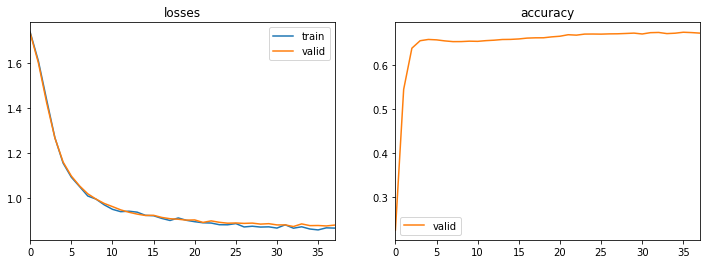

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[5.4557e-01, 2.1834e-01, 1.2855e-01, 7.4576e-02, 2.5024e-02, 7.9340e-03],
         [8.7167e-01, 7.9760e-02, 3.0394e-02, 1.0212e-02, 5.2461e-03, 2.7165e-03],
         [9.7635e-01, 1.9224e-02, 3.2256e-03, 8.9980e-04, 1.8838e-04, 1.1638e-04],
         ...,
         [9.7741e-01, 1.9398e-02, 2.2483e-03, 5.3998e-04, 2.2847e-04, 1.8052e-04],
         [9.8303e-01, 1.4130e-02, 2.0490e-03, 5.1554e-04, 1.6647e-04, 1.1033e-04],
         [8.7838e-01, 7.9828e-02, 2.6950e-02, 9.5666e-03, 3.4883e-03, 1.7838e-03]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.726848
f1 score:   0.674745


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_ResCNN', y_test_true)
np.save('y_pred_ResCNN', y_test_pred)